In [16]:
import numpy as np
import pandas as pd
from scipy import spatial, stats, cluster
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import plotting, input_data
from nilearn.datasets import fetch_atlas_schaefer_2018
import networkx as nx
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import bct
import glob
from pathlib import Path

%matplotlib inline

# Styles
sns.set_context('poster')
sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [17]:
def subjectmatrix2graphslist(filename, densities):
    """
    Toma un archivo csv con la matriz de input y devuelve una lista de grafos con la densidad de aristas correspondiente
    """

    correlation_matrix = pd.read_csv(
        filename,
        header=None
    )
    n = correlation_matrix.shape[0]
    correlation_matrix -= np.diag(np.ones(n))
    max_links = (n*n-n)//2
    tril_idx = np.tril_indices(n,-1)
    sorted_correlations = sorted(
        correlation_matrix.values[tril_idx].flatten(),
        reverse=True
    )

    Gs = []
    for d in densities:
        idx = int(d*max_links)
        threshold = sorted_correlations[idx]
        Gs.append(nx.from_pandas_adjacency(correlation_matrix>=threshold))

    return Gs

In [18]:
def extraer_lista_grafos(tipo_red, densities):
    path = r'../resources/DataSujetos' # use your path
    all_files = glob.glob(path + "/{}_suj*.csv".format(tipo_red))

    graphs = {}
    for filename in all_files:
        Gs = subjectmatrix2graphslist(filename, densities)
        name = Path(filename).stem
        graphs[name] = Gs

    return graphs

In [19]:
densities = np.linspace(0.025,0.15)

G_N1 = extraer_lista_grafos("N1", densities)
G_N2 = extraer_lista_grafos("N2", densities)
G_N3 = extraer_lista_grafos("N3", densities)
G_W = extraer_lista_grafos("W", densities)


In [20]:
def get_average_clustering(graphs):
    avg_clustering = []
    for name, Gs in graphs.items():
        avg_clustering_ = [nx.average_clustering(G) for G in Gs]
        avg_clustering.append(avg_clustering_)
    avg_clustering = np.vstack(avg_clustering)

    return avg_clustering

In [21]:
N1_average_clustering = get_average_clustering(G_N1)
N2_average_clustering = get_average_clustering(G_N2)
N3_average_clustering = get_average_clustering(G_N3)
W_average_clustering = get_average_clustering(G_W)

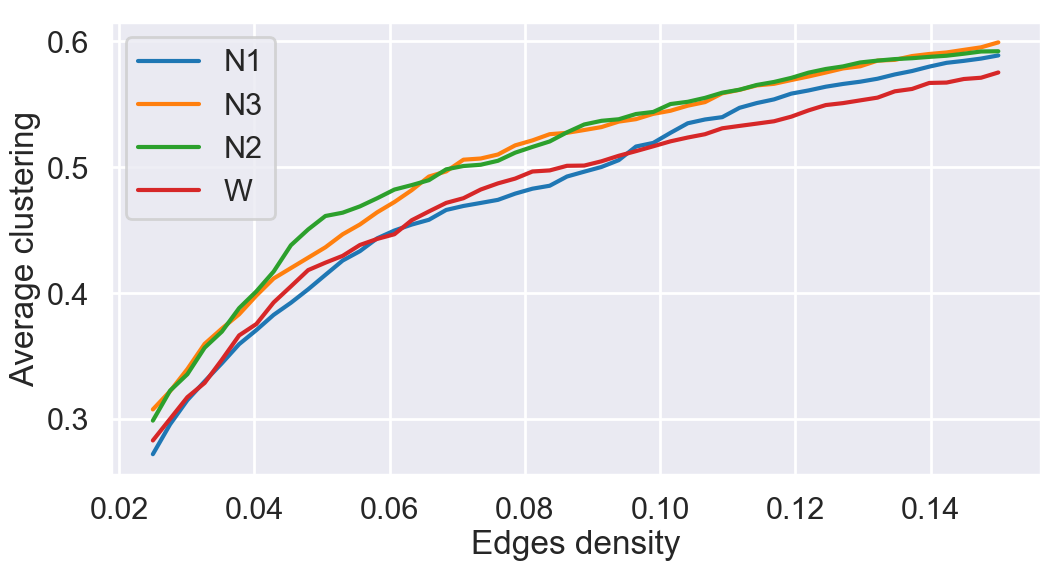

In [22]:
plt.plot(densities, N1_average_clustering.mean(0), label = "N1")
plt.plot(densities, N2_average_clustering.mean(0), label = "N3")
plt.plot(densities, N3_average_clustering.mean(0), label = "N2")
plt.plot(densities, W_average_clustering.mean(0), label = "W")
plt.xlabel('Edges density')
plt.ylabel('Average clustering')
plt.legend()
plt.show()

In [23]:
def get_avg_shortest_path(graphs):
    shortest_paths = []
    for name, Gs in graphs.items():
        shortest_paths_ = [max([nx.average_shortest_path_length(G.subgraph(c)) for c in nx.connected_components(G)]) for G in Gs]
        shortest_paths.append(shortest_paths_)
    shortest_paths = np.vstack(shortest_paths)

    return shortest_paths

In [24]:
N1_avg_shortest_path = get_avg_shortest_path(G_N1)
N2_avg_shortest_path = get_avg_shortest_path(G_N2)
N3_avg_shortest_path = get_avg_shortest_path(G_N3)
W_avg_shortest_path = get_avg_shortest_path(G_W)

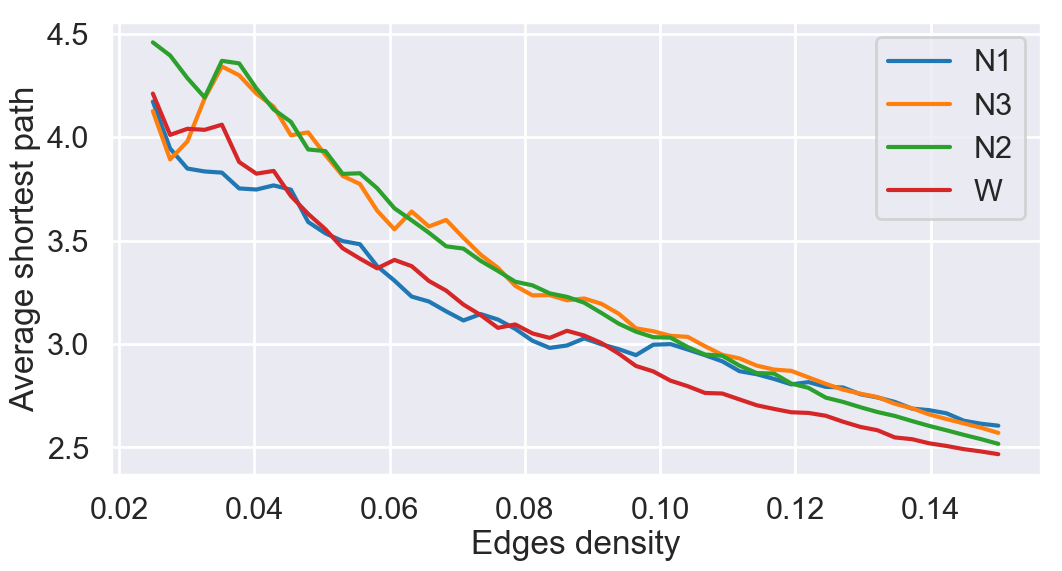

In [25]:
plt.plot(densities, N1_avg_shortest_path.mean(0), label = "N1")
plt.plot(densities, N2_avg_shortest_path.mean(0), label = "N3")
plt.plot(densities, N3_avg_shortest_path.mean(0), label = "N2")
plt.plot(densities, W_avg_shortest_path.mean(0), label = "W")
plt.xlabel('Edges density')
plt.ylabel('Average shortest path')
plt.legend()
plt.show()

In [26]:
def get_degree(graphs):
    degree = []
    for name, Gs in graphs.items():
        degree_ = [(G.number_of_edges()/G.number_of_nodes()) for G in Gs]
        degree.append(degree_)
    degree = np.vstack(degree)

    return degree

In [ ]:
N1_degree = get_degree(G_N1)
N2_degree = get_degree(G_N2)
N3_degree = get_degree(G_N3)
W_degree = get_degree(G_W)

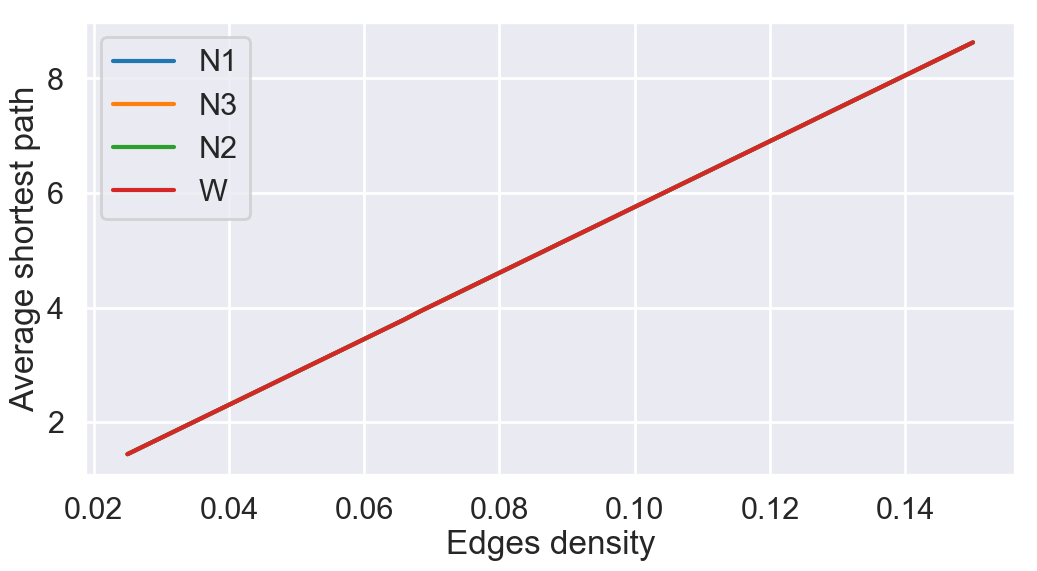

In [29]:
plt.plot(densities, N1_degree.mean(0), label = "N1")
plt.plot(densities, N2_degree.mean(0), label = "N3")
plt.plot(densities, N3_degree.mean(0), label = "N2")
plt.plot(densities, W_degree.mean(0), label = "W")
plt.xlabel('Edges density')
plt.ylabel('Average shortest path')
plt.legend()
plt.show()

In [61]:
def get_betweenness_centrality(graphs):
    centrality = []
    for name, Gs in graphs.items():
        centrality_ = [nx.betweenness_centrality(G) for G in Gs]
        value_ = [[max([v for n,v in Gcc]) for Gcc in Gc] for Gc in centrality_]
        centrality.append(value_)
    centrality = np.vstack(centrality)

    return centrality

In [62]:
N1_betweenness = get_betweenness_centrality(G_N1)

TypeError: 'int' object is not iterable

In [52]:
centrality = []
for name, Gs in G_N1.items():
    centrality_ = [nx.betweenness_centrality(G) for G in Gs]
    centrality.append(centrality_)


In [55]:
for Gc in centrality:
    
    print(max([v for n,v in Gc]))

ValueError: too many values to unpack (expected 2)

In [ ]:
plt.plot(densities, N1_betweenness.mean(0), label = "N1")
#plt.plot(densities, N2_degree.mean(0), label = "N3")
#plt.plot(densities, N3_degree.mean(0), label = "N2")
#plt.plot(densities, W_degree.mean(0), label = "W")
plt.xlabel('Edges density')
plt.ylabel('Average shortest path')
plt.legend()
plt.show()


In [ ]:

def extraer_grafo_promedio(tipo_red):
    path = r'../resources/DataSujetos' # use your path
    all_files = glob.glob(path + "/{}_suj*.csv".format(tipo_red))

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, header=None, index_col=None,)
        li.append(df)

    frame = pd.concat(li, axis=0)
    by_row_index = frame.groupby(frame.index)
    df_means = by_row_index.mean()

    thresh_cmat = bct.threshold_absolute(df_means.values, thr=.4)

    G = nx.from_numpy_matrix(thresh_cmat)
    return G

In [ ]:
G_N1_PROMEDIO = extraer_grafo_promedio("N1")
G_N2_PROMEDIO = extraer_grafo_promedio("N2")
G_N3_PROMEDIO = extraer_grafo_promedio("N3")
G_W_PROMEDIO = extraer_grafo_promedio("W")

In [ ]:
G_N1_PROMEDIO = extraer_grafo_promedio("N1")
G_N2_PROMEDIO = extraer_grafo_promedio("N2")
G_N3_PROMEDIO = extraer_grafo_promedio("N3")
G_W_PROMEDIO = extraer_grafo_promedio("W")

In [ ]:
G_N1_PROMEDIO = extraer_grafo_promedio("N1")
G_N2_PROMEDIO = extraer_grafo_promedio("N2")
G_N3_PROMEDIO = extraer_grafo_promedio("N3")
G_W_PROMEDIO = extraer_grafo_promedio("W")

In [ ]:
G_N1_PROMEDIO = extraer_grafo_promedio("N1")
G_N2_PROMEDIO = extraer_grafo_promedio("N2")
G_N3_PROMEDIO = extraer_grafo_promedio("N3")
G_W_PROMEDIO = extraer_grafo_promedio("W")

In [ ]:
G_N1_PROMEDIO = extraer_grafo_promedio("N1")
G_N2_PROMEDIO = extraer_grafo_promedio("N2")
G_N3_PROMEDIO = extraer_grafo_promedio("N3")
G_W_PROMEDIO = extraer_grafo_promedio("W")

In [ ]:
G_N1_PROMEDIO = extraer_grafo_promedio("N1")
G_N2_PROMEDIO = extraer_grafo_promedio("N2")
G_N3_PROMEDIO = extraer_grafo_promedio("N3")
G_W_PROMEDIO = extraer_grafo_promedio("W")

In [ ]:
G_N1_PROMEDIO = extraer_grafo_promedio("N1")
G_N2_PROMEDIO = extraer_grafo_promedio("N2")
G_N3_PROMEDIO = extraer_grafo_promedio("N3")
G_W_PROMEDIO = extraer_grafo_promedio("W")

In [ ]:
G_N1_PROMEDIO = extraer_grafo_promedio("N1")
G_N2_PROMEDIO = extraer_grafo_promedio("N2")
G_N3_PROMEDIO = extraer_grafo_promedio("N3")
G_W_PROMEDIO = extraer_grafo_promedio("W")

In [ ]:
G_N1_PROMEDIO = extraer_grafo_promedio("N1")
G_N2_PROMEDIO = extraer_grafo_promedio("N2")
G_N3_PROMEDIO = extraer_grafo_promedio("N3")
G_W_PROMEDIO = extraer_grafo_promedio("W")

In [ ]:
G_N1_PROMEDIO = extraer_grafo_promedio("N1")
G_N2_PROMEDIO = extraer_grafo_promedio("N2")
G_N3_PROMEDIO = extraer_grafo_promedio("N3")
G_W_PROMEDIO = extraer_grafo_promedio("W")

In [ ]:
G_N1_PROMEDIO = extraer_grafo_promedio("N1")
G_N2_PROMEDIO = extraer_grafo_promedio("N2")
G_N3_PROMEDIO = extraer_grafo_promedio("N3")
G_W_PROMEDIO = extraer_grafo_promedio("W")

In [ ]:
G_N1_PROMEDIO = extraer_grafo_promedio("N1")
G_N2_PROMEDIO = extraer_grafo_promedio("N2")
G_N3_PROMEDIO = extraer_grafo_promedio("N3")
G_W_PROMEDIO = extraer_grafo_promedio("W")

In [ ]:
G_N1_PROMEDIO = extraer_grafo_promedio("N1")
G_N2_PROMEDIO = extraer_grafo_promedio("N2")
G_N3_PROMEDIO = extraer_grafo_promedio("N3")
G_W_PROMEDIO = extraer_grafo_promedio("W")

In [ ]:
G_N1_PROMEDIO = extraer_grafo_promedio("N1")
G_N2_PROMEDIO = extraer_grafo_promedio("N2")
G_N3_PROMEDIO = extraer_grafo_promedio("N3")
G_W_PROMEDIO = extraer_grafo_promedio("W")

In [ ]:
def plot_degree_centrality_graph(G):
    pos_ = nx.spring_layout(G,k=0.2)

    centrality = nx.degree_centrality(G)
    values_ = [v for n,v in centrality.items()]

    nx.draw(
        G,
        pos=pos_,
        with_labels=True,
        font_weight='bold',
        node_color = values_,
        font_color='white',
        edge_color='gray'
    )

    sm = plt.cm.ScalarMappable(
        norm=plt.Normalize(
            vmin=min(values_),
            vmax=max(values_)
        )
    )
    sm.set_array([])
    plt.colorbar(sm)

    plt.suptitle('Centralidad de Grado',y=1.0)
    plt.tight_layout()

In [ ]:
plot_degree_centrality_graph(G_N1_PROMEDIO)

In [ ]:
plot_degree_centrality_graph(G_N2_PROMEDIO)

In [ ]:
plot_degree_centrality_graph(G_N3_PROMEDIO)

In [ ]:
plot_degree_centrality_graph(G_W_PROMEDIO)

In [ ]:
def get_betweenness_centrality(graphs):
    centrality = []
    for name, Gs in graphs.items():
        centrality_ = [nx.betweenness_centrality(G) for G in Gs]
        centrality.append(centrality_)
    centrality = np.vstack(centrality)

    return centrality

def get_closeness_centrality(graphs):
    centrality = []
    for name, Gs in graphs.items():
        centrality_ = [nx.closeness_centrality(G) for G in Gs]
        centrality.append(centrality_)
    centrality = np.vstack(centrality)

    return centrality

def get_eigen_vector_centrality(graphs):
    centrality = []
    for name, Gs in graphs.items():
        centrality_ = [nx.eigenvector_centrality(G) for G in Gs]
        centrality.append(centrality_)
    centrality = np.vstack(centrality)

    return centrality